In [2]:
import sys
sys.path.append('../scripts/')
from puddle_world import *
from dynamic_programming import *
from mcl import *
import itertools
import collections

In [16]:
class QmdpAgent(MclAgent):
    def __init__(self, time_interval, pf, widths, goal, puddles, sampling_num=10, \
                 puddle_coef=100.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): 
        super().__init__(time_interval, 0.0, 0.0, pf)
        self.dp = DynamicProgramming(widths, goal, puddles, time_interval, sampling_num) 
        
        self.update_end = False
        self.next_values = np.array([0.0, 0.0, 0.0])
        
        self.dp.value_function = self.init_value()
        
    def init_value(self):
        tmp = np.zeros(self.dp.index_nums)
        for line in open("value.txt", "r"):
            d = line.split()
            tmp[int(d[0]), int(d[1]), int(d[2])] = float(d[3])
            
        return tmp
        
    def action_value(self, action, index): #はみ出しペナルティーをゼロに
        value = 0.0
        for delta, prob in self.dp.state_transition_probs[(action, index[2])]: 
            after, edge_reward = self.dp.edge_correction(np.array(index).T + delta)
            after = tuple(after)
            reward = - self.dp.time_interval * self.dp.depths[(after[0], after[1])] * self.dp.puddle_coef - self.dp.time_interval
            value += (self.dp.value_function[after] + reward) * prob

        return value
    
    def policy(self, pose):
        next_values = np.array([0.0, 0.0, 0.0])
        for p in self.pf.particles:
            index = np.floor((p.pose - self.dp.pose_min)/self.dp.widths).astype(int) 
            index[2] = (index[2] + self.dp.index_nums[2]*1000)%self.dp.index_nums[2] #角度の正規化
            for i in [0,1]:   
                if index[i] < 0: index[i] = 0
                elif index[i] >= self.dp.index_nums[i]: index[i] = self.dp.index_nums[i] - 1
                    
            cur_value = self.dp.value_function[tuple(index)]
            next_values += (np.array([ self.action_value(a, index) for a in self.dp.actions ]) - cur_value)*p.weight

        self.next_values = next_values

        return self.dp.actions[np.argmax(next_values)]
    
    def decision(self, observation=None):
        if self.update_end:
            return 0.0, 0.0
            
        self.pf.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.pf.observation_update(observation)
        
        nu, omega = self.policy(self.pf.ml.pose)
        self.prev_nu, self.prev_omega = nu, omega
        return nu, omega

    def draw(self, ax, elems): 
        super().draw(ax, elems)
        elems.append(ax.text(-4, -4.5, str(self.next_values), fontsize=8))

<IPython.core.display.Javascript object>


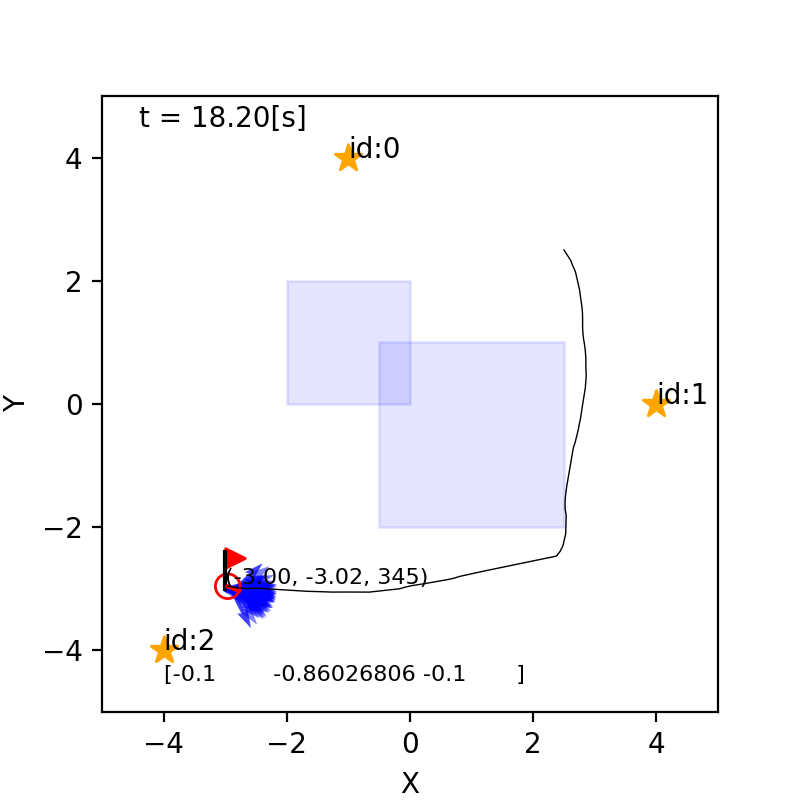

In [19]:
if __name__ == '__main__':  ###dppolicyagentrun
    time_interval = 0.1
    world = PuddleWorld(30, time_interval, debug=False) 

    m = Map()
    m.append_landmark(Landmark(-1,4))
#    m.append_landmark(Landmark(2,2))
    m.append_landmark(Landmark(4,0))
 #   m.append_landmark(Landmark(4,4))
    m.append_landmark(Landmark(-4,-4))
    world.append(m)
    
    ###ゴールの追加###
    goal = Goal(-3,-3)
    world.append(goal)
    
    ###水たまりの追加###
    puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)] 
    world.append(puddles[0]) 
    world.append(puddles[1])
    
    ### いくつかの初期位置を定義 ###   ###dppolicyagentrun

    init_pose = np.array([2.5, 2.5, 0]).T
    pf = Mcl(m, init_pose, 100)
    a = QmdpAgent(time_interval, pf,np.array([0.2, 0.2, math.pi/18]).T, Goal(-3,-3), puddles)
    r = Robot(init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0), 
              agent=a, color="red", bias_rate_stds=(0,0))

    world.append(r)
        
    world.draw()

In [ ]:
print(a.dp.value_function)

In [ ]:
a.update_end